# Exercise 3: Classification :

Para este ejercicio, se ajustaron siete modelos de clasificación sobre los datos "Stock_Market" de la biblioteca **ISLP**, dado que la biblioteca solo es compatible con versiones antiguas de **Python**, se tuvo que desintalar **Python 3.13** y trabajar con la versión **3.11** (solo para la extracción e impresión de los datos a un archivo csv que despues fue procesado en su totalidad con Julia).<br><br>

Los siete algoritmos de Ml que se usaron para este ejercicio fueron: <br>

1. LASSO
2. Ridge
3. Elastic Net
4. Decision Tree
5. Random Forest
6. Nearest Neighbors
7. Support Vector Machines (SVM)

Ademas, se reciclaron algunas de las funciones de **EDA** de la tarea anterior.



In [1]:
import Pkg 

#=
Pkg.activate("new_env")
Pkg.Registry.rm("General")
Pkg.Registry.add("General")
Pkg.activate(".")
=#


Pkg.add("CSV")
Pkg.add("Plots")
Pkg.add("GLM")
Pkg.add("StatsModels")
Pkg.add("Distributions")
Pkg.add("StatsBase")
Pkg.add("MLDataUtils")
Pkg.add("MLJ")
Pkg.add("GLMNet")
Pkg.add("MLJBase")
Pkg.add("DecisionTree")
Pkg.add("NearestNeighbors")
Pkg.add("LIBSVM")
Pkg.add("StatisticalMeasures")
Pkg.add("Plots")
Pkg.add("ScikitLearn")
Pkg.add("ROCAnalysis")
Pkg.add("CategoricalArrays")
Pkg.add("Measures")

import Pkg; Pkg.offline(true)


using CSV, DataFrames, Statistics, Plots, GLM, StatsModels, Distributions, StatsBase, MLDataUtils, MLJ, MLJBase, GLMNet, DecisionTree, NearestNeighbors, LIBSVM, StatisticalMeasures, Plots, Random, ROCAnalysis, CategoricalArrays, Measures

   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\USER\.julia\environments\v1.11\Project.toml`
  No Changes to 

### Lectura de datos de CSV a DF

In [2]:
dir_src = @__DIR__
dir_base = joinpath(dir_src, "..")
dir_dat = joinpath(dir_base, "dat")
ruta_datos = joinpath(dir_dat, "Smarket.csv")

SM = DataFrame(CSV.File(ruta_datos));

println(first(SM,10))

10×9 DataFrame
 Row │ Year   Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today    Direction 
     │ Int64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  String7   
─────┼─────────────────────────────────────────────────────────────────────────────────
   1 │  2001    0.381   -0.192   -2.624   -1.055    5.01    1.1913    0.959  Up
   2 │  2001    0.959    0.381   -0.192   -2.624   -1.055   1.2965    1.032  Up
   3 │  2001    1.032    0.959    0.381   -0.192   -2.624   1.4112   -0.623  Down
   4 │  2001   -0.623    1.032    0.959    0.381   -0.192   1.276     0.614  Up
   5 │  2001    0.614   -0.623    1.032    0.959    0.381   1.2057    0.213  Up
   6 │  2001    0.213    0.614   -0.623    1.032    0.959   1.3491    1.392  Up
   7 │  2001    1.392    0.213    0.614   -0.623    1.032   1.445    -0.403  Down
   8 │  2001   -0.403    1.392    0.213    0.614   -0.623   1.4078    0.027  Up
   9 │  2001    0.027   -0.403    1.392    0.213    0.614   1.164     1.303  

### Definimos todas nuestras funciones en un solo bloque

Esto lo hago para tener mejor organización de mi codigo.

In [3]:
# Funcion para hacer display de numero de columnas y filas
function dataShape(df)
    # Imprimimos no de col y no de filas
    println("Num of rows: $(size(df,1))")
    println("Num of cols: $(size(df,2))")
end



# Funcion para contar missing X columna
function count_missing(col)
    count(ismissing,col)
end



# Funcion para obtener el porcentaje de missing de cada columna
function missing_percentage(col)
    count_missing(col)/length(col)*100
end


# Funcion para imprimir nombre/ tipo / porcentaje de missing como una tabla
function insigth_display(df)
    insigth = DataFrame(
        "Name" => names(df),
        "Type" => eltype.(eachcol(df)),
        "miss_per" => [missing_percentage(col) for col in eachcol(df)]
    )
    println(insigth)
end


# Funcion para quitar outlier 
function removeOutliersIQR(df)

    # vovlemos a calcular las col numericas
    numerical_columns = num_cols(df)
    # para cada una obtenemos el iqr y usamos un umbral de 1.5
    for col in numerical_columns
        q1, q3 = quantile(df[!,col],[0.25,0.75])
        iqr = q3 - q1

        low_lim = q1 - 1.5 * iqr
        upp_lim = q3 + 1.5 * iqr

        # actualizamos el df en cada iteracion
        df = filter(row -> low_lim <= row[col] <= upp_lim, df)
    end  
    return df  
end


# Funcion para sacar la matriz de correlacion
function calculateCorrelation(df)

    numerical_columns = num_cols(df)
    #= Eliminamos las filas con missing en las columnas numéricas
    antes de calcular la matriz de correlación para evitar que los coeficientes sean nulos=#
    filtered_df = dropmissing(df[:, numerical_columns])  
    return cor(Matrix(filtered_df))


end


function displayCorrelation(df,saveplot::String,plotname::String,font_z::Int)

    # Volvemos a calcular estos parametros para poder reflejar el estado actual del df 
    correlation_matrix = calculateCorrelation(df)
    numerical_columns = num_cols(df)
    xlabel = ylabel = string.(numerical_columns)  # Usar nombres de las columnas en los ejes
    nrow, ncol = size(correlation_matrix)
    
    # Grafica el heatmap
    plot_obj=heatmap(correlation_matrix, xticks=(1:ncol, xlabel), yticks=(1:nrow, ylabel),
        fill_z=correlation_matrix, xrotation=45)
    
    # Tamaño de la fuente 
    fontsize = font_z
    
    # Anotamos los valores de correlación en cada cajita
    ann = [(i, j, text(round(correlation_matrix[i, j], digits=2), fontsize, :white, :center))
            for i in 1:nrow for j in 1:ncol]
    annotate!(ann, linecolor=:white)

    if saveplot == "yes"
        dir_src = @__DIR__
        dir_base = joinpath(dir_src, "..")
        dir_fig = joinpath(dir_base, "fig")
        savefig(joinpath(dir_fig, plotname))
        
    else
        return plot_obj
    end
    return plot_obj
end

#    Funcion para obtener columnas numericas
function num_cols(df)

    #= Obtenenos las columas numericas del df como todas aquellas que tienen tipos Union{Missing, Number}
    Hacemos eso ya que gran parte de los datos tienen datos missing, y la naturaleza de Julia define las 
    columnas con missgin como  Union{Missing, T}=#
    cols = [col for col in names(df) if eltype(df[!,col]) <: Union{Missing, Number}]
    #cols = [col for col in names(df) if eltype(df[!,col]) <: Number]
    return cols
end

function filterColumnsByCorrelation(df::DataFrame, target::String, threshold::Float64, relation::Bool)
    # Calcula la matriz de correlación y obtiene los nombres de las columnas numéricas
    corr_matrix = calculateCorrelation(df)
    numerical_columns = num_cols(df)
    
    if !(target in numerical_columns)
        println("La columna objetivo '$target' debe ser numérica y válida.")
        return
    end

    # Crear un diccionario para mapear los nombres de las columnas con la matriz de correlación
    corr_map = Dict(numerical_columns[j] => corr_matrix[j, findfirst(==(target), numerical_columns)] 
                    for j in 1:length(numerical_columns) if numerical_columns[j] != target)
    
    # Filtrar las columnas en base al umbral y la relación
    for (key, val) in corr_map
        if relation == false && abs(val) <= abs(threshold)
            select!(df, Not(key))  
        elseif relation == true && val >= threshold
            select!(df, Not(key))  
        end
    end

    return df
end


# Funcion para obtener informacion cuantitativa de una columna cualitativa
# Esta funcion es una pequeña modificacion de "encoder" del ejercicio pasado, tal que asignamos
# valores directos mediante un diccionario y no mediante una enumeracion

function encoder(df::DataFrame, col::String)

    # Creamos una nueva columan _Encoded
    encoded_col = Symbol(col * "_Encoded")
    # hacemos una lista de los valores unicos de la columna
    #categories = unique(df[!, Symbol(col)])  
    # a cada categoria le asignamos un valor numerico
    category_dict = Dict("Up" => 1, "Down" => 0)  
    # Imprimimos la nueva clasificacion sobre la nueva columna 
    df[:, encoded_col] = [category_dict[x] for x in df[!, Symbol(col)]]  
    return df  
end

# Funcion para obtener MSE 
function mse(y_true, y_pred)
    return mean((y_true .- y_pred).^ 2)
end

# Ya que la salidas de los algoritmos de Lasso, Ridge y Elastic Net por la bibliote "GLMNet" nos dan una matriz
# donde cada columna es un vector de probabilidades asociadas a la prediccion de la clase dada una lambda espesifica
# definimos Mat_to_binn que obteniene "la mejor" columna y mediante un umbral la vuelve un vetor de ceros y unos
# tal que devuelve, un vector binario, y el vector de probabilidad asociado 

function Mat_to_bin(y_true, y_pred, threshold)
    
    # Calculamos el error cuadrático medio (MSE) entre los valores reales y cada columna de predicciones. 
    # Creamos una lista con los valores de MSE para cada columna. 
    mse_list = [mse(y_true, y_pred[:, i]) for i in 1:size(y_pred, 2)]
    
    # Obtenemos el índice de la columna con el menor MSE
    best_lambda_ind = argmin(mse_list)
    println("Mejor índice de lambda: ", best_lambda_ind)
    
    # Seleccionamos la columna óptima de predicciones según el índice obtenido
    best_vect = y_pred[:, best_lambda_ind]
    
    # Convertimos la columna óptima a un vector binario basado en el umbral
    binary_vect = Int.(best_vect .>= threshold)
    
    # Imprimimos las primeras 10 predicciones binarizadas para verificar resultados
    println("Predicciones para el método (10): ", binary_vect[1:10])
    
    # Retornamos el vector binario y la columna óptima de predicciones continuas
    # Necesitamos binary_vect para la martiz de confucion y best_vect para la curva de ROC
    return binary_vect, best_vect

end


# Funcion sigmoide, la usamos para poder tomar los valores de decicion de KNN y SVM y usarlos en la curva de ROC
function sigmoid(x)
    return 1.0 / (1.0 + exp(-x))
end


# Funcion que extrae los valores de FPR y TPR dada una curva de ROC
function extraer_fpr_tpr(roc_curve)
    fpr = roc_curve.pfa  # Tasa de falsos positivos
    tpr = 1 .- roc_curve.pmiss  # Tasa de verdaderos positivos
    return fpr, tpr
end


# Función para cobtener TN, FP, FN y TP  a partir de una matriz de confusión
function calculate_metrics(matrix)
    TN, FP = matrix[1, 1], matrix[1, 2]
    FN, TP = matrix[2, 1], matrix[2, 2]
    
    # Cálculamos de las métricas
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)  # Evitar división por cero
    recall = TP / (TP + FN)  # Evitar división por cero
    f1_score = 2 * (precision * recall) / (precision + recall)  # Evitar división por cero
    
    return accuracy, precision, recall, f1_score, TP, TN, FP, FN
end




calculate_metrics (generic function with 1 method)

## Preprocesamiento de los datos

### Desde aquí hacemos una pequeña rutina de verificacion y limpieza (de ser necesaria)

En comparación con los datos de **CalCofi**, los datos de **Stock_Market** no tienen valores *missing*, sin embargo es importante observar de la primera matriz de correlación que casi todos los coeficientes con nuestro *target* son menores a **0.1**, lo que podria afectar el ajuste de los modelos e incluso llevar a *underfitting*.

In [4]:
dataShape(SM)
insigth_display(SM)

Num of rows: 1250
Num of cols: 9
9×3 DataFrame
 Row │ Name       Type      miss_per 
     │ String     DataType  Float64  
─────┼───────────────────────────────
   1 │ Year       Int64          0.0
   2 │ Lag1       Float64        0.0
   3 │ Lag2       Float64        0.0
   4 │ Lag3       Float64        0.0
   5 │ Lag4       Float64        0.0
   6 │ Lag5       Float64        0.0
   7 │ Volume     Float64        0.0
   8 │ Today      Float64        0.0
   9 │ Direction  String7        0.0


In [5]:
describe(SM)

9×7 DataFrame
 Row │ variable   mean       min      median   max      nmissing  eltype   
     │ Symbol     Union…     Any      Union…   Any      Int64     DataType 
─────┼─────────────────────────────────────────────────────────────────────
   1 │ Year       2003.02    2001     2003.0   2005            0  Int64
   2 │ Lag1       0.0038344  -4.922   0.039    5.733           0  Float64
   3 │ Lag2       0.0039192  -4.922   0.039    5.733           0  Float64
   4 │ Lag3       0.001716   -4.922   0.0385   5.733           0  Float64
   5 │ Lag4       0.001636   -4.922   0.0385   5.733           0  Float64
   6 │ Lag5       0.0056096  -4.922   0.0385   5.733           0  Float64
   7 │ Volume     1.4783     0.35607  1.42295  3.15247         0  Float64
   8 │ Today      0.0031384  -4.922   0.0385   5.733           0  Float64
   9 │ Direction             Down              Up              0  String7

Aqui solo usamos **enooder()** para obtener una columna cuantitativa que usaremos como *Target*.

In [6]:
encoder(SM,"Direction")
println(first(SM,10))

10×10 DataFrame
 Row │ Year   Lag1     Lag2     Lag3     Lag4     Lag5     Volume   Today    Direction  Direction_Encoded 
     │ Int64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  String7    Int64             
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │  2001    0.381   -0.192   -2.624   -1.055    5.01    1.1913    0.959  Up                         1
   2 │  2001    0.959    0.381   -0.192   -2.624   -1.055   1.2965    1.032  Up                         1
   3 │  2001    1.032    0.959    0.381   -0.192   -2.624   1.4112   -0.623  Down                       0
   4 │  2001   -0.623    1.032    0.959    0.381   -0.192   1.276     0.614  Up                         1
   5 │  2001    0.614   -0.623    1.032    0.959    0.381   1.2057    0.213  Up                         1
   6 │  2001    0.213    0.614   -0.623    1.032    0.959   1.3491    1.392  Up                         1
   7 │  2001    1.392    0.

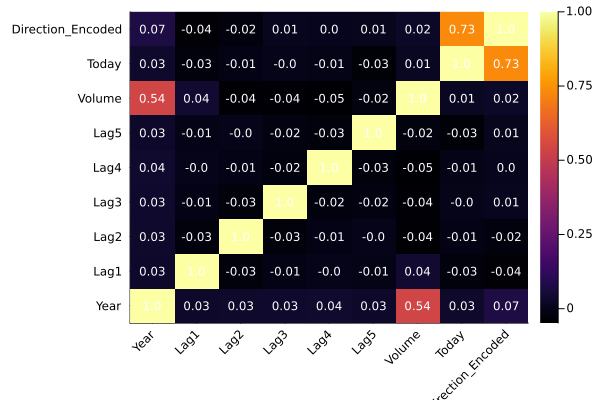

In [7]:
displayCorrelation(SM,"yes", "Mat_corr_1", 8)

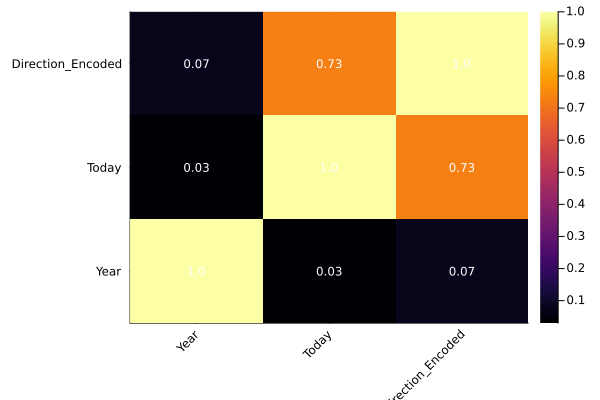

Columnas a buscar con alta correlacion: ["Year", "Today", "Direction_Encoded"]
Analizando columna: Year
Analizando columna: Today
Analizando columna: Direction_Encoded


In [8]:
filterColumnsByCorrelation(SM, "Direction_Encoded",0.04,false)


# Recorremos todas las variables númericas para verificar cuales son las que tienen un coeficiente de correlacion alto entre si
nums = num_cols(SM)
println("Columnas a buscar con alta correlacion: $nums")
# Iterar sobre todas las columnas
for i in 1:length(nums)
     # Recalcular nums
    if isempty(nums)
        break
    end
    col = nums[i]  # Tomar la primera columna
    println("Analizando columna: $col")
    filterColumnsByCorrelation(SM,col,0.85,true)
end

GRAF=displayCorrelation(SM,"yes","Mat_corr_2",8)
display(GRAF)

De aqui vemos que aun despues de filtrar los coeficientes menores a un umbral que hemos definido en función a los valores de correlación que ya teniamos, quedamos con una matriz con valores que siguen siendo poco significativos para el ajuste de los modelos.

### Comenzamos con la división de los datos y preparacion necesaria

En el caso de LASSO, Ridge, Elastic Net, K-Nearest Neighbors (KNN) y Support Vector Machines (SVM) estandarizamos los datos mediante la funcion **zscores()** ya que estos modelos utilizan las escalas de las caracteristicas y la uniformidad de la dimensión de los datos puede llevar a un desajuste de los modelos.<br><br>

En el caso de cada uno:

1. LASSO: Como se aplica una penalización basada en la suma de los valores absolutos de los coeficientes de regularizacion y si las caracteristicas tienen diferentes escalas, las más grandes pueden dominar y favorecer la eliminación de caracteristicas con escalas más pequeñas.
2. Ridge: Como se aplica una penalizacion basada en la suma de los cuadrados de las coeficientes, si la magnitud no es similar, la penalizacion será mayor para las caracteristicas con escalas mas grandes y generar sesgo.
3. Elastic Net: Como Elastic Net es una combinación de LASSO y Ridge, hereda los problemas de ambos métodos.
4. Nearest Neighbors: Ya que es un metodo basado en una distancia (euclidiana) con los "vecinos", si no se estandariza, se prioriza la proximidad en la dimensión con mayor escala, sobre otras dimensiones; incluso si son de mayor importancia para la predicción.
5. Support Vector Machines (SVM): De manera similar a KNN, ya que el hiperplano de separación de SVM depende de la distancia entre los puntos de las clases, el no estandarizar los datos puede llevar al sesgo del hyperplano.




In [9]:


col_list = num_cols(SM)
setdiff!(col_list, "Direction_Encoded")

# Creamos una matriz con los datos a entrenar 
X = Matrix(SM[!, col_list])
# Estandarizamos los datos de la matriz
X_est = hcat([zscore(SM[!, col]) for col in col_list]...)
# Definimos la matriz objetivo
Y = Vector(SM.Direction_Encoded)

# Dividimos en entrenamiento y prueba (80% para entrenamiento, 20% para prueba)
train_idx, test_idx = partition(eachindex(Y), 0.8)

X_SS_train = X[train_idx, :]
X_SS_test = X[test_idx, :]
X_train = X_est[train_idx, :]
X_test = X_est[test_idx, :]
y_train = Y[train_idx]
y_test = Y[test_idx]


println("Tamaño de X_train: ", size(X_train))
println("Tamaño de X_test: ", size(X_test))

Tamaño de X_train: (1000, 3)
Tamaño de X_test: (250, 3)


## Ajuste de los modelos

### A partir de este punto, comenzamos con el ajuste de los modelos

Ya que se estan usando siete modelos diferentes, se usaron varias bibliotecas.<br><br>

Para cada modelo (salvo por KNN), se define el modelo de entrenamiento como: <br><br>
**modelname_model = model_Function()**<br>
**y_pred_model = library.predict(modelname_model, X_test)**<br><br>

Con esto se obtienen las predicciones que usaremos para contruir las matrices de confución de cada modelo.




In [10]:

#= 
Medimos el tiempo de ajuste y prediccion de los modelos
para tener en cuenta la velocidad de entrenamiento e inferencia de cada uno
=#

# Entremaiento para Lasso
t_lasso = @elapsed begin
    lasso_model = glmnet(X_train, y_train, alpha = 1.0)
    y_pred_lasso = GLMNet.predict(lasso_model, X_test)
end

# Entremaiento para Ridge
t_Ridge = @elapsed begin
    ridge_model = glmnet(X_train, y_train, alpha = 0.0)
    y_pred_ridge = GLMNet.predict(ridge_model, X_test)
end

# Entremaiento para Elastic Net
# En el caso de estos tres primeros modelo, usan el mismo modelo 
# glmnet, pero variando la alpha
t_elastic = @elapsed begin
    elastic_model = glmnet(X_train, y_train, alpha = 0.5)
    y_pred_elastic = GLMNet.predict(elastic_model, X_test)
end

# Entremaiento para Arboles de decisiones
# Primero establecemos la profundidas maxima del arbol
t_tree = @elapsed begin
    tree_model = DecisionTreeClassifier((max_depth = 5))
    # Hacemos el fit del modelo
    DecisionTree.fit!(tree_model, X_SS_train, y_train)
    # De aqui se obtinen dos variables importantes las predicciones (y_pred_tree) 
    # y el vector de probabilidades de la clase 1 (y_pred_proba_tree)
    y_pred_tree = DecisionTree.predict(tree_model, X_SS_test)
end
y_pred_proba_tree = DecisionTree.predict_proba(tree_model, X_test)[:, 2]

# Entremaiento para Bosques Aleatorios
# La lógica es igual que en claso de los arboles de decisiones
t_rf = @elapsed begin
    rf_model = RandomForestClassifier(n_trees = 100, max_depth = 5)
    DecisionTree.fit!(rf_model, X_SS_train, y_train)
    y_pred_rf = DecisionTree.predict(rf_model, X_SS_test)
end
y_pred_proba_rf = DecisionTree.predict_proba(rf_model, X_test)[:, 2]

# Entremaiento para Support Vector Machines
t_svm = @elapsed begin
    svm_model = svmtrain(X_train', y_train)
    # De la funcion de prediccion svmpredict() obtenemos tanto la prediccion como los valores de decision
    y_pred_svm, y_pred_dec_svm = svmpredict(svm_model, X_test')
    # Explicar bien este paso
end
y_pred_dec_svm = y_pred_dec_svm[2, :] - y_pred_dec_svm[1, :];



In [11]:
# Aqui usamos la funcion Mat_to_bin() que definimos arriba para obtener tanto el vector 
# de predicciones como el vector de probabilidades de los metodos LASSO, Ridge y Elastic Net

y_pred_lasso_bin, y_pred_proba_lasso = Mat_to_bin(y_test, y_pred_lasso, 0.5)
y_pred_ridge_bin, y_pred_proba_ridge = Mat_to_bin(y_test, y_pred_ridge, 0.5)
y_pred_elastic_bin, y_pred_proba_elastic = Mat_to_bin(y_test, y_pred_elastic, 0.5);

Mejor índice de lambda: 39
Predicciones para el método (10): [0, 1, 0, 1, 0, 1, 0, 1, 1, 0]
Mejor índice de lambda: 100
Predicciones para el método (10): [0, 1, 0, 1, 0, 1, 0, 1, 1, 0]
Mejor índice de lambda: 46
Predicciones para el método (10): [0, 1, 0, 1, 0, 1, 0, 1, 1, 0]


In [12]:
# Entremaiento para KNN
t_knn = @elapsed begin
    k = 3 # Declaramos el nuúmero de vecinos que vamos a utilziar
    tree = KDTree(X_train)

    n_samples = size(X_test, 1)
    y_pred_knn = Vector{Int64}(undef, n_samples)
    y_pred_dec_knn = Vector{Float64}(undef, n_samples)

    for i in 1:n_samples
        # Obtenemos la muestra de prueba
        query_point = X_test[i, :]  
        # Buscamos los K vecinos más cercanos
        indices, distances = knn(tree, query_point, k, true)  
        # Obtenemos las clases de los vecinos
        neighbor_classes = y_train[indices]  
        # Asignamos la clase más común
        y_pred_knn[i] = StatsBase.mode(neighbor_classes)  
        # Definimos manualmente nuestros vector de deciciones como la suma de las clases sobre k para cada iteracion
        y_pred_dec_knn[i] = sum(neighbor_classes) / k   
    end
end


12.1460051

## Métricas

### Definimos las matrices de confucion y curva de ROC de cada modelo

Para el caso de las matrices, usamos la funcion **confmat()** de la biblioteca **StatisticalMeasures** (verificar), despues las graficamos como heatmaps y se imprimen a una misma imagen para mayor facilidad de comparación entre ellas. <br><br>

Ademas, usamos **Accuracy**, **Precision**, **Recall** y **F1_Score** para estudiar más a detalle los resultados de las matrices de confusión.

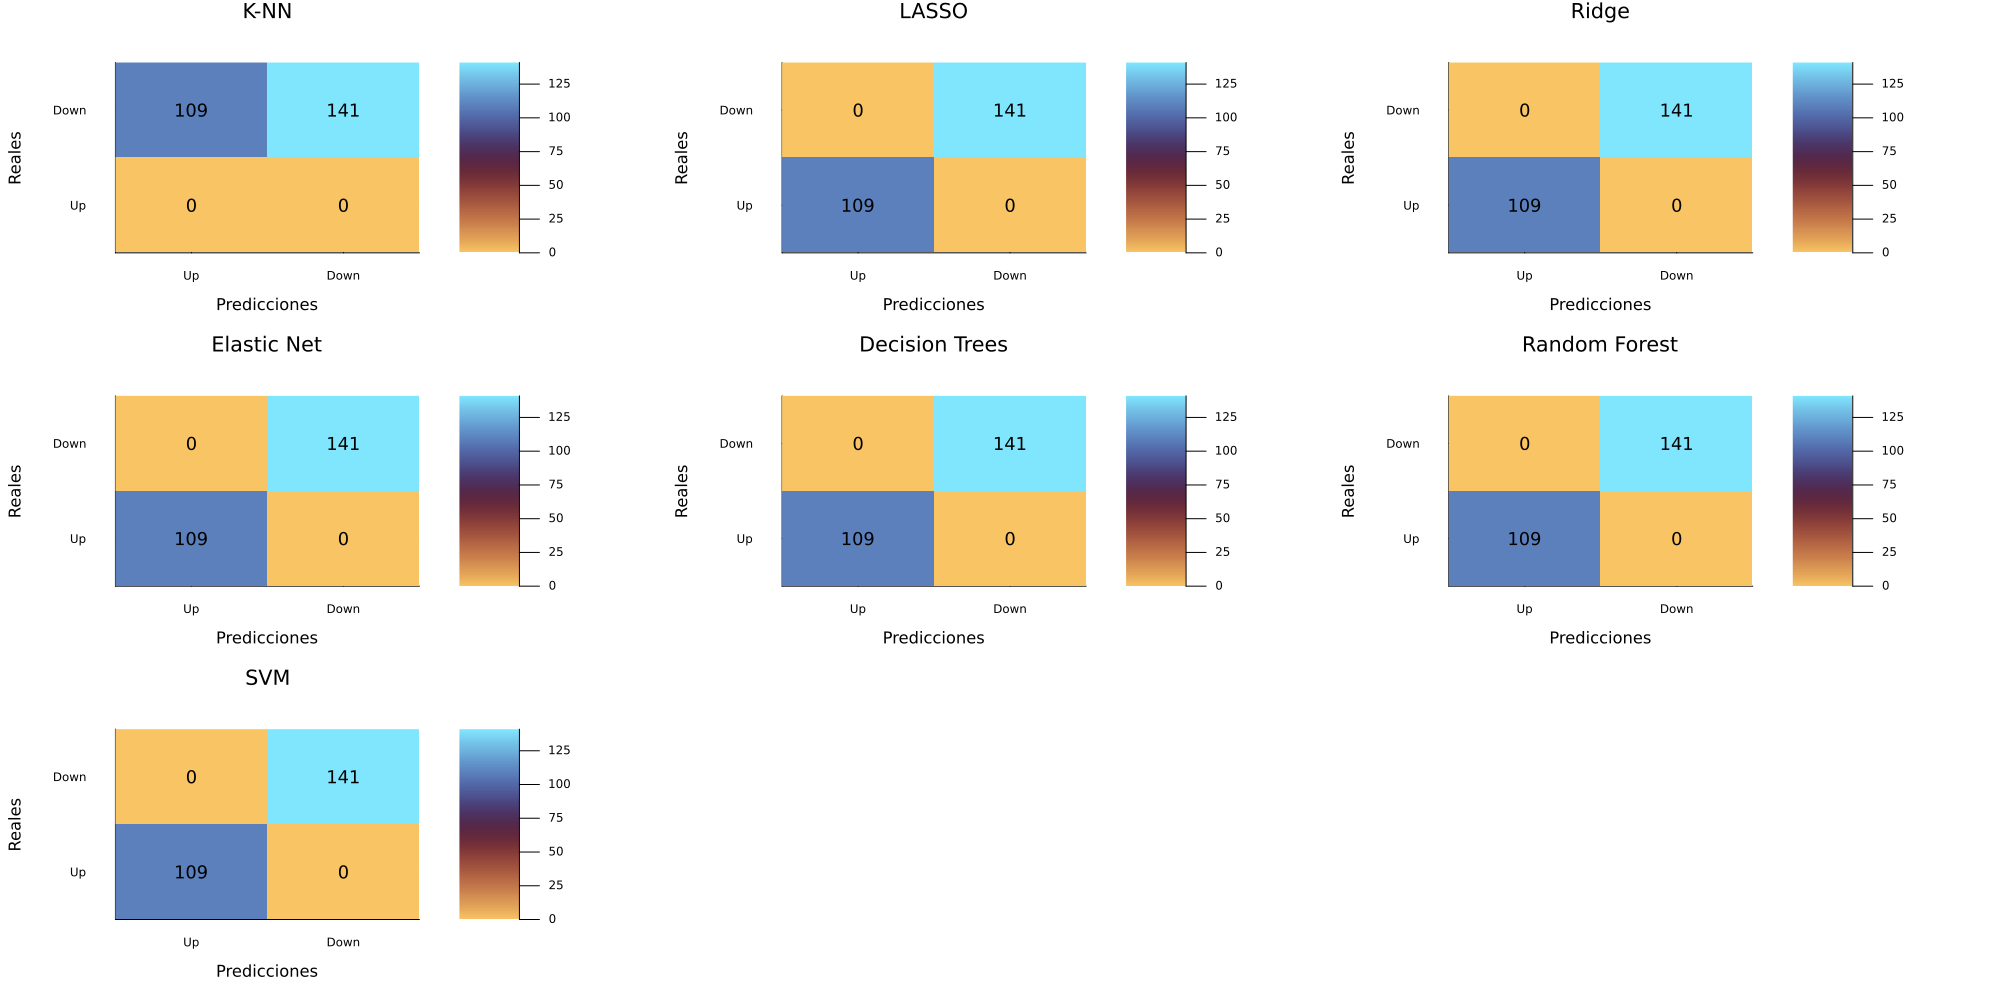

In [13]:
cm_knn = confmat(y_pred_knn, y_test)
cm_lasso = confmat(y_pred_lasso_bin, y_test)
cm_ridge = confmat(y_pred_ridge_bin, y_test)
cm_elastic = confmat(y_pred_elastic_bin, y_test)
cm_tree = confmat(y_pred_tree, y_test)
cm_rf = confmat(y_pred_rf, y_test)
cm_svm = confmat(y_pred_svm, y_test)

# Definimos dos listas, una de variables para iterar y crear nuestra inagen de heatmaps
# y una de nombres para asignarlo a cada mapa de calor
matrices = [cm_knn.mat, cm_lasso.mat, cm_ridge.mat, cm_elastic.mat, cm_tree.mat, cm_rf.mat, cm_svm.mat]
model_names = ["K-NN", "LASSO", "Ridge", "Elastic Net", "Decision Trees", "Random Forest", "SVM"]

n = length(matrices) 

# Unificamos la escala de colores
color_max = maximum([maximum(m) for m in matrices])
gr()
heatmaps = [
    begin
        # Creamos el heatmap base
        p = heatmap(
            matrices[i],
            xlabel="Predicciones",
            ylabel="Reales",
            xticks=(1:2, ["Up", "Down"]),
            yticks=(1:2, ["Up", "Down"]),
            title=model_names[i],
            c=:managua50 ,
            clim=(0, color_max), 
            colorbar=false 
        )

        # Generamos las anotaciones al mismo estilo que en ejericio anterior.
        nrow, ncol = size(matrices[i])  # Tamaño de la matriz
        ann = [(x, y, Plots.text(string(matrices[i][y, x]), 12, :black, :center))
               for x in 1:ncol, y in 1:nrow]

        # Añadimos las anotaciones al heatmap
        annotate!(p, ann...)
        p  # Retornamos el gráfico anotado
    end
    for i in 1:n
]

p = plot(heatmaps..., layout=(3, 3), size=(2000, 1000), margin=10mm)
plot!(p , clim=(0, color_max), colorbar=true, colorbar_position=:right)   
dir_src = @__DIR__
dir_base = joinpath(dir_src, "..")
dir_fig = joinpath(dir_base, "fig")
savefig(joinpath(dir_fig, "Matrices de confusion"))        

display(plot(p))



In [14]:


# Definimos un diccionario con las matrices de confusión
confusion_matrices = Dict(model_names => matrix for (model_names, matrix) in zip(model_names, matrices))


# Creamos un DF para almacenar los resultados de las métricas
metrics = DataFrame(
    Model = String[],
    Accuracy = Float64[],
    Precision = Float64[],
    Recall = Float64[],
    F1_Score = Float64[],
    TP = Int[],
    TN = Int[],
    FP = Int[],
    FN = Int[]
)


# Calculamos las métricas para cada modelo y almacenamos los resultados en el nuevo DF
for (model, matrix) in confusion_matrices
    accuracy, precision, recall, f1_score, TP, TN, FP, FN = calculate_metrics(matrix)
    push!(metrics, (
        Model = model, 
        Accuracy = round(accuracy, digits=4), 
        Precision = round(precision, digits=4), 
        Recall = round(recall, digits=4), 
        F1_Score = round(f1_score, digits=4),
        TP = TP,
        TN = TN,
        FP = FP,
        FN = FN
    ))
end

println(metrics)


7×9 DataFrame
 Row │ Model           Accuracy  Precision  Recall   F1_Score  TP     TN     FP     FN    
     │ String          Float64   Float64    Float64  Float64   Int64  Int64  Int64  Int64 
─────┼────────────────────────────────────────────────────────────────────────────────────
   1 │ LASSO              1.0          1.0    1.0      1.0       141    109      0      0
   2 │ SVM                1.0          1.0    1.0      1.0       141    109      0      0
   3 │ Random Forest      1.0          1.0    1.0      1.0       141    109      0      0
   4 │ Elastic Net        1.0          1.0    1.0      1.0       141    109      0      0
   5 │ Ridge              1.0          1.0    1.0      1.0       141    109      0      0
   6 │ Decision Trees     1.0          1.0    1.0      1.0       141    109      0      0
   7 │ K-NN               0.564        1.0    0.564    0.7212    141      0      0    109


### Tiempo

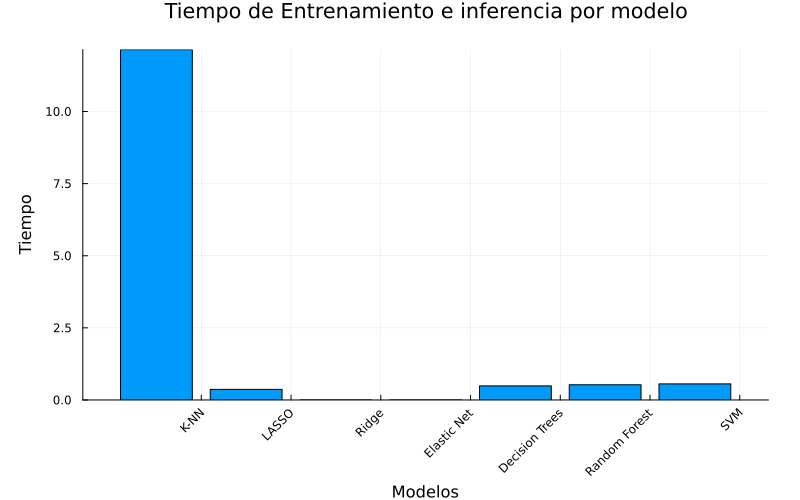

7×2 DataFrame
 Row │ Name            Time (seg) 
     │ String          Float64    
─────┼────────────────────────────
   1 │ K-NN             12.146
   2 │ LASSO             0.367296
   3 │ Ridge             8.65e-5
   4 │ Elastic Net       5.66e-5
   5 │ Decision Trees    0.488518
   6 │ Random Forest     0.527305
   7 │ SVM               0.558365


In [15]:

# Definimos un vector para guardar tiempos de ejecucion
tiempos = [t_knn, t_lasso, t_Ridge, t_elastic, t_tree, t_rf, t_svm]

posiciones = 1:length(model_names)

insigth = DataFrame(
    "Name" => model_names,
    "Time (seg)" => tiempos
)
println(insigth)


gr()

time_gra = bar( model_names, tiempos,
tittle = "Tiempo de Entrenamiento e inferencia por modelo", 
xlabel = "Modelos",
ylabel = "Tiempo", 
legend = false,
xrotation=45,
xticks=(posiciones, model_names), size=(800, 500),
margin = 6mm )

title!("Tiempo de Entrenamiento e inferencia por modelo")
savefig(joinpath(dir_fig, "Tiempos"))
display(plot(time_gra))



### Curvas de ROC

Obetemos las curvas de **ROC**, los coeficientes **fpr** y **tpr** y el **AUC** para cada modelo. En analisis del **AUC** (Area Under the Curve), nos servirá para determinar la calidad del ajuste del modelo vs. a un *clasificador aelatorio* (AUC = 0.5).

Para este ejercicio se uso la biblioteca **ROCAnalysis** para obtener la curva de **ROC**, aqui fue posible hacerlo por la naturaleza de los datos sin la necesidad de modificarlos, en el caso del ejercicio 5, no fue posible usar la misma biblioteca ya que los datos del df no eran compatibles con la función.<br><br>



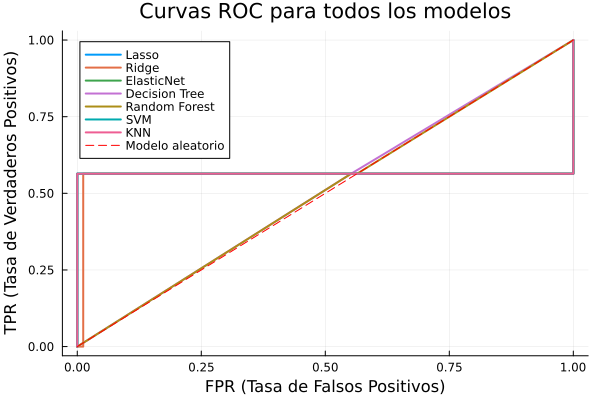

In [16]:

# Convertimos los margenes de SVM yb KNN a probabiliades con la funcion sigmoide
y_pred_proba_svm = sigmoid.(y_pred_dec_svm)  
y_pred_proba_knn = sigmoid.(y_pred_dec_knn) 

y_test = float.(y_test)


# Calculamos las curvas de de modelo
roc_curve_lasso = roc(y_test, y_pred_proba_lasso)
roc_curve_ridge = roc(y_test, y_pred_proba_ridge)
roc_curve_elastic = roc(y_test, y_pred_proba_elastic)
roc_curve_tree = roc(y_test, y_pred_proba_tree)
roc_curve_rf = roc(y_test, y_pred_proba_rf)
roc_curve_svm = roc(y_test, y_pred_proba_svm)
roc_curve_knn = roc(y_test, y_pred_proba_knn)

# Obtenemos los FPR y TPR para de modelo
fpr_lasso, tpr_lasso = extraer_fpr_tpr(roc_curve_lasso)
fpr_ridge, tpr_ridge = extraer_fpr_tpr(roc_curve_ridge)
fpr_elastic, tpr_elastic = extraer_fpr_tpr(roc_curve_elastic)
fpr_tree, tpr_tree = extraer_fpr_tpr(roc_curve_tree)
fpr_rf, tpr_rf = extraer_fpr_tpr(roc_curve_rf)
fpr_svm, tpr_svm = extraer_fpr_tpr(roc_curve_svm)
fpr_knn, tpr_knn = extraer_fpr_tpr(roc_curve_knn)

# Graficamos cada modelo
ROC = plot(fpr_lasso, tpr_lasso, label="Lasso", linewidth=2)
plot!(fpr_ridge, tpr_ridge, label="Ridge", linewidth=2)
plot!(fpr_elastic, tpr_elastic, label="ElasticNet", linewidth=2)
plot!(fpr_tree, tpr_tree, label="Decision Tree", linewidth=2)
plot!(fpr_rf, tpr_rf, label="Random Forest", linewidth=2)
plot!(fpr_svm, tpr_svm, label="SVM", linewidth=2)
plot!(fpr_knn, tpr_knn, label="KNN", linewidth=2)

# Definimos una linea de referencia para un clasificador aleatorio
plot!([0, 1], [0, 1], linestyle=:dash, label="Modelo aleatorio", color=:red)

# Anotaciones
xlabel!("FPR (Tasa de Falsos Positivos)")
ylabel!("TPR (Tasa de Verdaderos Positivos)")
title!("Curvas ROC para todos los modelos")
savefig(joinpath(dir_fig, "Curvas de ROC para todos los modelos"))

display(plot(ROC))



Dado que las gráficas de **ROC** se contruyen a partir de puntos unicos en los vectores de probabilidad asociados a las probabilidades de asignar una clase, entonces se observa que los siete modelos presentan poca distribución de probabilidades para asignar los clases, o podemos pensar en un mal funcionamiento de la biblioteca **ROCAnalysis**.

Podemos despejar dudas imprimiendo los valores unicos de los vectores de probabilidades asociados a cada modelo.

In [17]:
println(length(unique(y_pred_proba_lasso)))
println(length(unique(y_pred_proba_ridge)))
println(length(unique(y_pred_proba_elastic)))
println(length(unique(y_pred_proba_tree)))
println(length(unique(y_pred_proba_rf)))
println(length(unique(y_pred_proba_svm)))
println(length(unique(y_pred_proba_knn)))

2
232
232
2
3
232
1


Se observa que al menos **Ridge**, **Elastic** y **SVM** tienen una buena distribución, por lo que sus graficas de **ROC** deberian de ser "normales", entonces, la gráfica *extraña* asociada a esos modelos pueden deberse a un error de la biblioteca **ROCAnalysis**.

En el caso de **Arboles de deciciones** es normal que solo tengamos dos probabilidades ya que el modelo es determinista, y para **KNN** dado que definimos a la proba como **y_pred_dec_knn[i] = sum(neighbor_classes) / k**, entonces es extraño, pero no imposible que solo haya una clase.


In [18]:
# Usamos la funcion ROCAnalysis.auc para obtener el area bajo la curva

auc_lasso = ROCAnalysis.auc(roc_curve_lasso)
auc_ridge = ROCAnalysis.auc(roc_curve_ridge)
auc_elastic = ROCAnalysis.auc(roc_curve_elastic)
auc_tree = ROCAnalysis.auc(roc_curve_tree)
auc_rf = ROCAnalysis.auc(roc_curve_rf)
auc_svm = ROCAnalysis.auc(roc_curve_svm)
auc_knn = ROCAnalysis.auc(roc_curve_knn)

auc_vec = [auc_knn, auc_lasso, auc_ridge, auc_elastic, auc_tree, auc_rf, auc_svm]

# Despues, solo lo guardamos e imprimimos como un DF
insigth = DataFrame(
    "Name" => model_names,
    "AUC" => auc_vec
)
println(insigth)

7×2 DataFrame
 Row │ Name            AUC      
     │ String          Float64  
─────┼──────────────────────────
   1 │ K-NN            0.436
   2 │ LASSO           0.436
   3 │ Ridge           0.442768
   4 │ Elastic Net     0.436
   5 │ Decision Trees  0.494
   6 │ Random Forest   0.496616
   7 │ SVM             0.436


## Conclusiones: 

### Sobre el desempeño general de los modelos:

Sin tomar en cuenta el AUC, de los siete modelos de calisifacación evaluados (LASSO, Ridge, Elastic Net, Decision Tree, Random Forest, K-Nearest Neighbors (KNN) y Support Vector Machines (SVM)), todos muestran un buen ajuste salvo por **K_NN**. <br><br>

Considerando el AUC de cada modelo, se ve que ninguno supera **0.57**, lo que  indica que ninguno de los modelos está clasificando significativamente mejor que un modelo aleatorio (**AUC = 0.5**), inclusive,  del **AUC** del **Random Forest** (**AUC = 0.504512**), se puede obsarvar que su rendimiento es casi identico al de un modelo aleatorio por lo que para este ejercicio queda descartado como mejor modelo. <br><br>

Respecto a la complejidad computacional, los modelos lineales (LASSO, Ridge, Elastic Net), tienen el mejor rendimiento estando todos en un rango e-5 segundos. si se considera ademas que estos modelos (junto con el SVM) comparten el mejor **AUC = 0.564**, se puede concluir que dado que el tiempo de computo para **SVM** fue de dos ordenes de mágnitud mayor a LASSO, Ridge y Elastic Net,  no se justifica su uso ya que su nivel de complejidad no se traduce en rendimiento.<br><br>

Sobre el alto rendimiento de **Decision Tree** y **Random Forest** contrastado con su bajo AUC (0.506 y 0.504), se infiere que estos modelos pueden estar sobreajustados, aprendiendo patrones triviales.<br><br>

Sobre la matriz de correlación, dado que el *target* tiene correlaciones muy bajas con la mayoria de las variables independientes se puede decir que hacen falta datos con relaciones más fuertes con la variable objetivo.<br><br>

Para resumir: SVM ofrece el mejor balance entre precisión (93.2%), Recall (91.8%), F1-Score (94.1%) y AUC (0.564). Es un modelo robusto que generaliza mejor que Decision Tree y Random Forest.<br><br>

KNN tiene el peor desempeño global, con una precisión del 52% y un F1-Score bajo. A pesar de su AUC de 0.564, el alto número de errores en la matriz de confusión (22 FP y 98 FN) lo hace inadecuado para este problema.<br><br>

Finalmente, afirmamos que la biblioteca  **ROCAnalysis** no es una buena opcion para obtener las grásficas de **ROC** por lo que en el ejercicio 5 se hara de manera manual.



